[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/broad-1/quickstarters/cnn/cnn.ipynb)

# Broad Institute: Autoimmune Disease Machine Learning Challenge

![Cover](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/broad-1/cover.jpg)

## Crunch 1 – Quickstarter Computer Vision

## The Problem

Autoimmune diseases arise when the immune system mistakenly targets healthy cells. Affecting 50M people in the U.S., with rising global cases, Inflammatory Bowel Disease (IBD) is one of the most prevalent forms. IBD involves a breakdown in the gut barrier, triggering the immune system to attack proteins erroneously recognized as foreign, leading to persistent inflammation. This cycle of flares and remission increases the risk of colorectal cancer (up to two-fold). Although modern treatments have improved survival, IBD remains challenging to diagnose and treat due to its complex symptoms and multifactorial nature.
Pathologists rely on gut tissue images to diagnose and treat IBD, guiding decisions on the most suitable drug treatments and predicting cancer risk. These tissue images, combined with recent advances in genomics, offer a valuable dataset for machine learning models to revolutionize IBD diagnosis and treatment.

## The Solution

In Crunch 1, you will train an algorithm to predict spatial transcriptomics data (gene expression in each cell). In other words predict the gene expression (Y) in cells from specific tissue patches based on the H&E images (X) and surrounding spatial transcriptomics data.

#### X (Input):

- **HE_registered**: The registered H&E image, aligned to the Xenium spatial transcriptomics coordinate system. This is the recommended file to use as it is already aligned with the spatial transcriptomics data.

- **HE_original**: The original H&E image in its native pixel coordinates, before alignment. If you prefer to handle alignment yourself, you can use this, but it may require additional processing.

#### Y (Output):

- **anucleus**: This file contains the aggregated gene expression data for each nucleus. It is log1p-normalized and stores the gene expression profiles for 460 genes per nucleus. This is the primary target (Y) for your model.

- **transcripts**: This file contains the spatial locations and individual gene expression data for each transcript in the tissue, linked to specific nuclei. It provides the raw gene expression information before aggregation.

## Environment setup


- Environment variables are configured to specify the API and web base URLs.
- The `crunch-cli` package is upgraded to the latest version.
- The notebook is set up to interact with the competition using a provided token.Update the token via https://hub.crunchdao.io/competitions/broad/submit/via/notebook


In [ ]:
%pip install --upgrade crunch-cli

In [ ]:
# Registering to this Crunch

# Step 1:
# Create an account here: https://hub.crunchdao.com/auth/register

# Step 2:
# Get your set token here: https://hub.crunchdao.com/competitions/broad-1/submit/via/notebook
!crunch setup --notebook broad hello --token aaaabbbbccccddddeeeeffff

## Import
IMPORTANT: For each library import, in order to avoid any issue related to the library version, it is strongly recommended to specify the version of the library you are using. This to ensure that the notebook will be reproducible in the Crunch Foundation environment without any undesirable modification to the behavior of your code.

In [4]:
%pip install spatialdata-plot -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Data Handling and Analysis
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Spatial Data Processing
import spatialdata as sd
import scanpy as sc
from scipy.spatial import KDTree
from skimage import filters, measure, color
import tifffile
import crunch

# Load Crunch CLI in notebook mode
crunch = crunch.load_notebook()

# Visualization
import matplotlib.pyplot as plt
import spatialdata_plot
from skimage.measure import regionprops

# TensorFlow for Model Development
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Loading all datasets

In [6]:
# Unziping datasets
# Iterate through the list ["test", "train"], representing directories to process
for directory in tqdm(["test", "train"]):
    # Construct the full path to each directory (e.g., "data/test/" or "data/train/")
    directory = f"data/{directory}/"

    # Iterate through each file in the current directory
    for file in tqdm(os.listdir(directory)):
        # Skip files that do not have a ".zip" extension
        if not file.endswith(".zip"):
            continue

        # Change to the directory and unzip the current file using a system command
        os.system(f"cd {directory}; unzip {file}")

In [3]:
sdata = sd.read_zarr(f"data/train/UC1_NI.zarr")
sdata

/home/skhotijah/baseline/crunch/.venv/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /home/skhotijah/baseline/crunch/data/train/UC1_NI.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 21000, 22000)
│     └── 'HE_original': DataArray[cyx] (3, 21000, 22000)
└── Tables
      ├── 'anucleus': AnnData (80037, 460)
      └── 'cell_id-group': AnnData (93686, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

In [5]:
sdata['anucleus'].X # normalized data
sdata['anucleus'].layers['counts'] # raw data

array([[1, 0, 9, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 1, ..., 0, 0, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Input (X)

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.034188036..1.0].


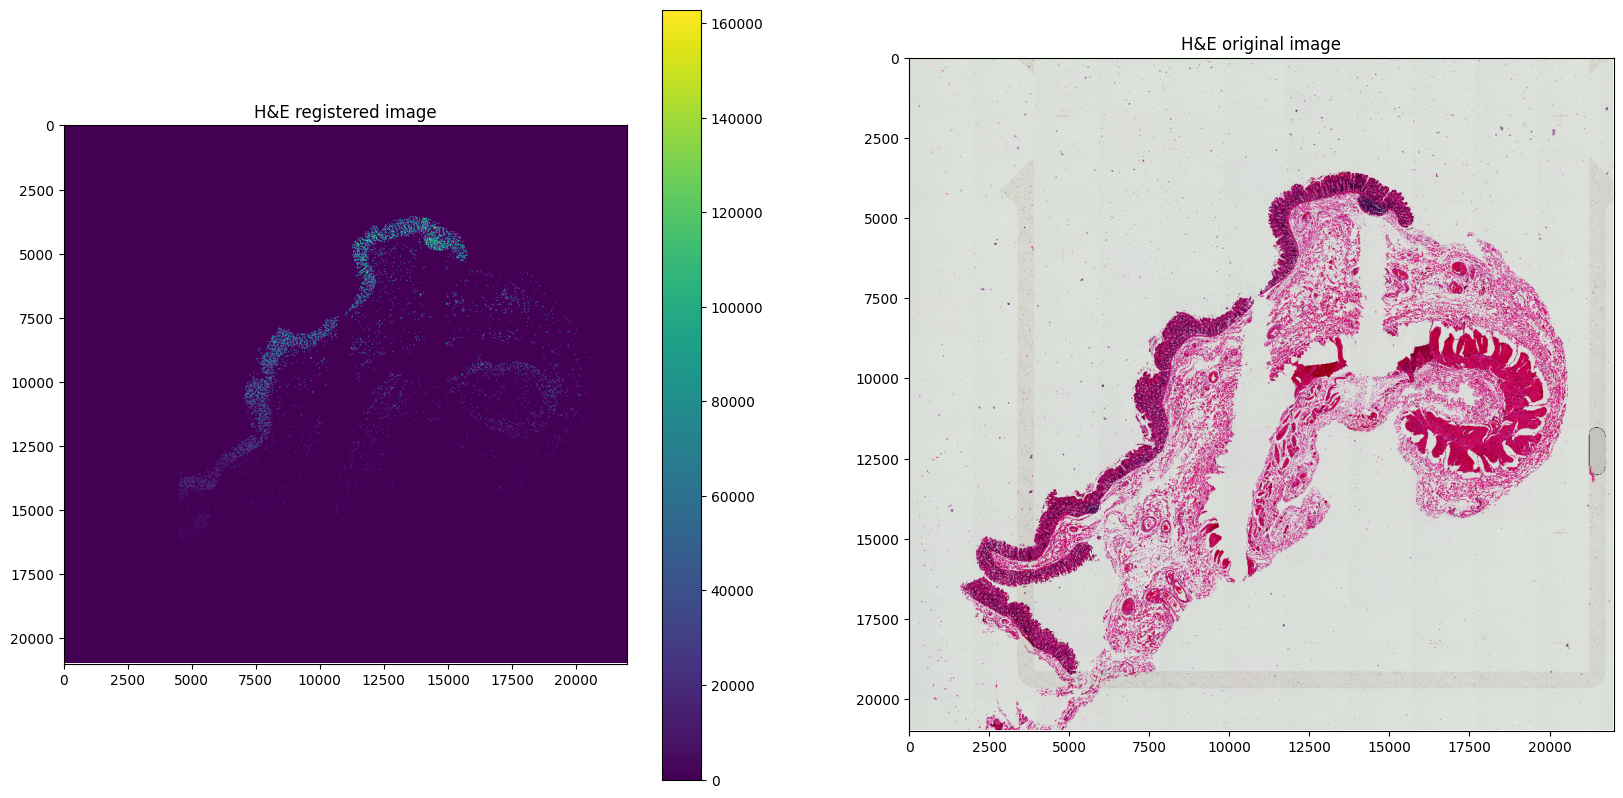

In [9]:
##  H&E pathology image
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the axes to easily index them

sdata.pl.render_images("HE_nuc_original").pl.show(ax=axes[0], title="H&E registered image", coordinate_systems="global")
sdata.pl.render_images("HE_original").pl.show(ax=axes[1], title="H&E original image", coordinate_systems="global")

## Target (Y)

In [6]:
## Selecting a random subsamble of 100 cell in the training sample
cell_id_example = sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']['cell_id'].to_numpy()[:100]
cell_id_example = list(set(cell_id_example).intersection(set(sdata['anucleus'].obs['cell_id'].unique())))

## Get y from the anucleus data
ground_truth_example = sdata['anucleus'].layers['counts'][sdata['anucleus'].obs['cell_id'].isin(cell_id_example),:]

## Get the list of gene concerned in crunch 1
gene_name_list = sdata['anucleus'].var['gene_symbols'].values
print(gene_name_list[:10])

['A2M' 'ACP5' 'ACTA2' 'ADAMTSL3' 'AFAP1L2' 'AHR' 'ALDH1B1' 'ANO1' 'ANXA1'
 'AQP1']


In [7]:
y = pd.DataFrame(ground_truth_example, columns= gene_name_list, index = cell_id_example)
y

,A2M,ACP5,ACTA2,ADAMTSL3,AFAP1L2,AHR,ALDH1B1,ANO1,ANXA1,AQP1,...,VCAN,VIL1,VIM,VPREB3,VWA5A,WFDC2,XBP1,XCL2,XCR1,ZEB2
1,1,0,9,0,0,0,0,0,2,0,...,0,0,4,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,12,0,...,0,0,3,0,0,0,0,0,0,0
3,2,0,1,0,2,4,0,0,0,0,...,0,0,9,0,0,0,0,0,0,2
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,6,0,0,0,0,0,2,0,...,0,0,3,0,1,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,0,0,0,0,0,0,0,0,...,1,0,5,0,0,0,0,0,0,0
107,2,0,1,0,0,0,0,0,1,0,...,0,0,3,0,0,0,0,0,0,1
108,8,0,0,0,1,1,0,0,0,13,...,0,0,3,0,0,0,1,0,0,2
109,4,0,4,0,0,0,0,0,0,1,...,0,0,4,0,0,0,0,0,0,1


### Check Training, Test Data, and Validation Data

In [8]:
# Check unique groups in the cell_id-group
group_counts = sdata['cell_id-group'].obs['group'].value_counts()
print("Group counts:\n", group_counts)

Group counts:
 group
train         80037
test           7474
validation     6175
Name: count, dtype: int64


In [9]:
# Get all unique cell IDs for train and test groups
train_cell_ids = sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']['cell_id'].unique()
test_cell_ids = sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'test']['cell_id'].unique()

print(f"Number of training cells: {len(train_cell_ids)}")
print(f"Number of testing cells: {len(test_cell_ids)}")

Number of training cells: 80037
Number of testing cells: 7474


In [10]:
# Selecting a random subsample of 100 cells in the training sample
cell_id_example = sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']['cell_id'].to_numpy()[:100]

# Check if the sampled cell IDs are in the training set
sampled_train_cells = set(cell_id_example).intersection(set(train_cell_ids))
print(f"Number of sampled cells in train: {len(sampled_train_cells)}")

# Verify that the sampled cells are unique
if len(sampled_train_cells) != 100:
    print("Warning: Not all sampled cells are unique or available in the training set.")

# Check the ground truth for the sampled cells
ground_truth_example = sdata['anucleus'].layers['counts'][sdata['anucleus'].obs['cell_id'].isin(cell_id_example),:]

# Check the shape of the ground truth
print(f"Ground truth shape: {ground_truth_example.shape}")

Number of sampled cells in train: 100
Ground truth shape: (100, 460)


In [11]:
# Get the list of gene concerned in crunch 1
gene_name_list = sdata['anucleus'].var['gene_symbols'].values
print("First 10 genes:\n", gene_name_list[:10])

# Create DataFrame for the ground truth
y = pd.DataFrame(ground_truth_example, columns=gene_name_list, index=cell_id_example)
print(y.head())

First 10 genes:
 ['A2M' 'ACP5' 'ACTA2' 'ADAMTSL3' 'AFAP1L2' 'AHR' 'ALDH1B1' 'ANO1' 'ANXA1'
 'AQP1']
   A2M  ACP5  ACTA2  ADAMTSL3  AFAP1L2  AHR  ALDH1B1  ANO1  ANXA1  AQP1  ...  \
1    1     0      9         0        0    0        0     0      2     0  ...   
2    0     0      0         0        0    0        0     0     12     0  ...   
3    2     0      1         0        2    4        0     0      0     0  ...   
4    1     0      0         0        0    0        0     0      0     0  ...   
5    1     0      6         0        0    0        0     0      2     0  ...   

   VCAN  VIL1  VIM  VPREB3  VWA5A  WFDC2  XBP1  XCL2  XCR1  ZEB2  
1     0     0    4       0      0      0     0     0     0     0  
2     0     0    3       0      0      0     0     0     0     0  
3     0     0    9       0      0      0     0     0     0     2  
4     0     0    0       0      0      0     0     0     0     0  
5     0     0    3       0      1      0     0     0     0     3  

[5 rows x 460 co

## Data Preparation

In [4]:
def save_cropped_cells(sdata, crop_size=128, out_dir='image_crop'):
    """
    Function to save cropped cell images from the original intensity image.

    Parameters:
    sdata: SpatialData object containing the image data.
    crop_size: Size of the square crop around each cell's centroid.
    out_dir: Directory where the cropped images will be saved.
    """
    # Create output directory if it doesn't exist
    os.makedirs(out_dir, exist_ok=True)

    # Get regions from the nucleus image
    regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

    # Get the original intensity image
    intensity_image = sdata['HE_original'].to_numpy()

    # Half of the crop size to calculate boundaries
    half_crop = crop_size // 2

    crop_list = []

    # Loop through each region and extract the crop
    for props in tqdm(regions):
        cell_id = props.label
        centroid = props.centroid
        y_center, x_center = int(centroid[0]), int(centroid[1])

        # Calculate the crop boundaries
        minr, maxr = y_center - half_crop, y_center + half_crop
        minc, maxc = x_center - half_crop, x_center + half_crop

        # Ensure boundaries are within the image dimensions
        pad_top = max(0, -minr)
        minr = max(0, minr)

        pad_bottom = max(0, maxr - intensity_image.shape[1])
        maxr = min(maxr, intensity_image.shape[1])

        pad_left = max(0, -minc)
        minc = max(0, minc)

        pad_right = max(0, maxc - intensity_image.shape[2])
        maxc = min(maxc, intensity_image.shape[2])

        # Crop and pad the image if needed
        if pad_top + pad_bottom + pad_left + pad_right > 0:
            crop = np.pad(intensity_image[:, minr:maxr, minc:maxc],
                          ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right)),
                          mode='constant', constant_values=0)
        else:
            crop = intensity_image[:, minr:maxr, minc:maxc]

        crop_list.append(crop)
        
        # Save the crop as a TIFF file
        tifffile.imwrite(f"{out_dir}/{cell_id}.tif", crop.astype('uint8'), metadata={'axes': 'CYX'})

    return crop_list

# Call the function with your sdata
cropped_cells = save_cropped_cells(sdata, crop_size=128, out_dir='image_crop')


100%|██████████| 93686/93686 [02:03<00:00, 755.98it/s] 


In [25]:
# Step 1: Save Cropped Cells
crop_size = 128
save_cropped_cells(sdata, crop_size=crop_size, out_dir='image_crop')

100%|██████████| 93686/93686 [01:14<00:00, 1249.93it/s]


[array([[[223, 221, 222, ..., 207, 208, 202],
         [219, 222, 221, ..., 210, 209, 203],
         [216, 216, 220, ..., 211, 208, 210],
         ...,
         [213, 212, 212, ..., 176, 204, 206],
         [211, 212, 212, ..., 196, 204, 208],
         [214, 213, 213, ..., 201, 210, 210]],
 
        [[219, 219, 225, ...,  85,  85,  93],
         [221, 217, 217, ...,  87,  82,  89],
         [212, 201, 210, ...,  89,  89,  87],
         ...,
         [ 81,  78,  73, ...,  37,  46,  49],
         [ 80,  83,  81, ...,  43,  50,  51],
         [ 82,  91, 104, ...,  51,  55,  55]],
 
        [[221, 217, 218, ..., 166, 162, 167],
         [218, 217, 218, ..., 167, 162, 165],
         [217, 209, 215, ..., 167, 166, 164],
         ...,
         [166, 162, 159, ...,  92, 116, 130],
         [160, 162, 163, ..., 107, 127, 134],
         [164, 169, 173, ..., 125, 135, 140]]], dtype=uint8),
 array([[[219, 218, 218, ..., 194, 209, 210],
         [217, 216, 208, ..., 202, 207, 207],
         [218, 2

In [8]:
# Step 2: Prepare Data for Training
cell_group_df = sdata['cell_id-group'].obs[['cell_id', 'group']].copy()

# Create train and test sets based on the group
train = cell_group_df[cell_group_df['group'] == 'train'].copy()
test = cell_group_df[cell_group_df['group'] == 'test'].copy()

# Specify a range of available cell_ids (1 to 50)
selected_cell_ids = set(range(1, 51))  # Adjust this range if necessary

# Ensure cell_id is of the same data type in both DataFrames
train.loc[:, 'cell_id'] = train['cell_id'].astype('int64')
test.loc[:, 'cell_id'] = test['cell_id'].astype('int64')

# Print unique cell_ids in the test set before filtering
print("Unique cell_ids in test group before filtering:", test['cell_id'].unique())

# Filter to keep only selected cell_ids for training and testing
train_df = train[train['cell_id'].isin(selected_cell_ids)]
test_df = test[test['cell_id'].isin(selected_cell_ids)]

# Check the unique cell_ids after filtering
print(f"Unique cell_ids in filtered train_df: {train_df['cell_id'].unique()}")
print(f"Unique cell_ids in filtered test_df: {test_df['cell_id'].unique()}")

# Check if there are enough samples for training and testing
if len(train_df) > 30:
    train_df = train_df.sample(n=30, random_state=42)  # Sample 30 training samples

if len(test_df) > 30:
    test_df = test_df.sample(n=30, random_state=42)  # Sample 30 testing samples

# Optional: Print shapes or counts to verify
print(f"Number of training samples: {len(train_df)}")
print(f"Number of testing samples: {len(test_df)}")

# Optional: Print unique cell_ids to verify
print(f"Unique cell_ids in train_df: {train_df['cell_id'].unique()}")
print(f"Unique cell_ids in test_df: {test_df['cell_id'].unique()}")


Unique cell_ids in test group before filtering: [65548 65550 65555 ... 65513 65515 65518]
Unique cell_ids in filtered train_df: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48 49 50]
Unique cell_ids in filtered test_df: [21 39]
Number of training samples: 30
Number of testing samples: 2
Unique cell_ids in train_df: [29 43 28 46 26 40 13 20  5 27  9  4  7 42 35 14 18 48 16 10 17 31 34 49
  1 33 32  6 12 36]
Unique cell_ids in test_df: [21 39]


In [9]:
print(f"Available cell IDs in sdata['anucleus']: {sdata['anucleus'].obs['cell_id'].unique()}")


Available cell IDs in sdata['anucleus']: [     1      2      3 ... 162952 162953 162955]


In [10]:
# Create mapping for training dataset
train_cell_id_to_index = {cell_id: idx for idx, cell_id in enumerate(train_df['cell_id'])}

# Create mapping for test dataset
test_cell_id_to_index = {cell_id: idx for idx, cell_id in enumerate(test_df['cell_id'])}


In [12]:
train_cell_id_to_index

{29: 0,
 43: 1,
 28: 2,
 46: 3,
 26: 4,
 40: 5,
 13: 6,
 20: 7,
 5: 8,
 27: 9,
 9: 10,
 4: 11,
 7: 12,
 42: 13,
 35: 14,
 14: 15,
 18: 16,
 48: 17,
 16: 18,
 10: 19,
 17: 20,
 31: 21,
 34: 22,
 49: 23,
 1: 24,
 33: 25,
 32: 26,
 6: 27,
 12: 28,
 36: 29}

In [11]:
test_cell_id_to_index

{21: 0, 39: 1}

In [64]:
# Access the 'anucleus' AnnData object
anucleus_data = sdata['anucleus']

# Extract the gene names from the 'var' attribute of the AnnData object
gene_names = anucleus_data.var.index.tolist()  # Assuming gene names are in the index of var

# Display the gene names
print("Gene Names List:", gene_names)

Gene Names List: ['A2M', 'ACP5', 'ACTA2', 'ADAMTSL3', 'AFAP1L2', 'AHR', 'ALDH1B1', 'ANO1', 'ANXA1', 'AQP1', 'AQP8', 'AREG', 'ASCL2', 'ATIC', 'AVIL', 'AXL', 'BANK1', 'BATF', 'BCAS1', 'BMX', 'BNC2', 'BTNL9', 'C1QA', 'C1QC', 'C3', 'C7', 'CA1', 'CA2', 'CA4', 'CA7', 'CADM1', 'CADPS', 'CALCB', 'CARD9', 'CAV1', 'CBLB', 'CCK', 'CCL1', 'CCL11', 'CCL13', 'CCL19', 'CCL2', 'CCL20', 'CCL22', 'CCL23', 'CCL24', 'CCL3L1', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCNB1', 'CCR1', 'CCR2', 'CCR3', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CD163', 'CD163L1', 'CD19', 'CD1C', 'CD2', 'CD209', 'CD22', 'CD247', 'CD27', 'CD300E', 'CD36', 'CD38', 'CD3D', 'CD3G', 'CD4', 'CD40LG', 'CD5', 'CD55', 'CD6', 'CD68', 'CD69', 'CD7', 'CD79A', 'CD83', 'CD86', 'CD8A', 'CD8B', 'CD9', 'CDC20', 'CDCA7', 'CDHR5', 'CDK1', 'CDK15', 'CDKN2B', 'CEACAM1', 'CEACAM7', 'CELF2', 'CES1', 'CES2', 'CFTR', 'CHAT', 'CHGB', 'CHI3L1', 'CLC', 'CLCA4', 'CLEC10A', 'CLEC9A', 'CMTM2', 'CNRIP1', 'COL14A1', 'COL4A2', 'COL6A3', 'CORO1A', 'COX4I2', 'CRTAM', 'CSF1

In [65]:
def data_generator(data_df, cell_id_to_index, sdata, gene_names, batch_size=32):
    num_samples = len(data_df)
    
    if num_samples == 0:
        # Handle case where there are no samples to generate
        return iter([])  # Return an empty iterator
    
    # Get the index mapping of gene names to their respective positions
    gene_name_to_index = {gene_name: idx for idx, gene_name in enumerate(gene_names)}

    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        X_batch = []
        y_batch = []  # To store gene expression data

        for i in range(start, end):
            cell_id = data_df['cell_id'].iloc[i]
            if cell_id in cell_id_to_index:
                index = cell_id_to_index[cell_id]
                if index < sdata['HE_original'].shape[1]:  # Ensure index is within bounds
                    cell_image = sdata['HE_original'][0, :, :].values[index]
                    X_batch.append(cell_image)
                    
                    # Retrieve the gene expression data for this cell
                    gene_expression_data = sdata['anucleus'].layers['counts'][index, :]  # Use appropriate indexing
                    y_batch.append(gene_expression_data)

        if X_batch:  # Only yield if there are images loaded
            yield np.array(X_batch), np.array(y_batch)

# Assuming you have previously loaded sdata and extracted gene_names as shown in previous messages
train_gen = data_generator(train_df, train_cell_id_to_index, sdata, gene_names)
test_gen = data_generator(test_df, test_cell_id_to_index, sdata, gene_names)

# To get a batch of data
try:
    X_train_batch, y_train_batch = next(train_gen)
    print(f"X_train_batch shape: {X_train_batch.shape}, y_train_batch shape: {y_train_batch.shape}")
except StopIteration:
    print("No more training data available.")

try:
    X_test_batch, y_test_batch = next(test_gen)
    print(f"X_test_batch shape: {X_test_batch.shape}, y_test_batch shape: {y_test_batch.shape}")
except StopIteration:
    print("No more testing data available.")


X_train_batch shape: (30, 22000), y_train_batch shape: (30, 460)
X_test_batch shape: (2, 22000), y_test_batch shape: (2, 460)


In [66]:
# Define constants
crop_size = 128  # This is your desired crop size, adjust if necessary
num_classes = 460  # Adjust according to your specific use case
batch_size = 4
epochs = 20  # Adjust as necessary

# Check the shapes of the input data
print("Original shapes:")
print(f"X_train_batch shape: {X_train_batch.shape}")
print(f"X_test_batch shape: {X_test_batch.shape}")


Original shapes:
X_train_batch shape: (30, 22000)
X_test_batch shape: (2, 22000)


In [67]:
# Reshape input data based on actual dimensions
# Determine the expected dimensions
expected_height = 220  # Adjust this based on actual data dimensions
expected_width = 100  # Adjust this based on actual data dimensions

# Check if the data can be reshaped to these dimensions
if X_train_batch.shape[1] == expected_height * expected_width:
    X_train = X_train_batch.reshape(X_train_batch.shape[0], expected_height, expected_width, 1)
    X_test = X_test_batch.reshape(X_test_batch.shape[0], expected_height, expected_width, 1)
else:
    raise ValueError(f"Cannot reshape: expected {expected_height * expected_width}, but got {X_train_batch.shape[1]}.")

# Check the reshaped data shapes
print("Reshaped shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Reshaped shapes:
X_train shape: (30, 220, 100, 1)
X_test shape: (2, 220, 100, 1)


In [68]:
# Data augmentation (optional)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)


## Modeling



In [69]:
# Fit the model
model = models.Sequential()
model.add(layers.Input(shape=(expected_height, expected_width, 1)))  # Update to match new shape
model.add(layers.Conv2D(16, (3, 3), strides=(2, 2), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.GlobalAveragePooling2D())  # Reduces dimensions while preserving essential features
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Adds regularization
model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Change as per your label encoding
              metrics=['accuracy'])

# Fit the model with reshaped training data
model.fit(X_train, y_train_batch, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.0000e+00 - loss: 411.8394 - val_accuracy: 0.0000e+00 - val_loss: 929.0591
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0190 - loss: 452.5904 - val_accuracy: 0.0000e+00 - val_loss: 849.3594
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0976 - loss: 431.2145 - val_accuracy: 0.0000e+00 - val_loss: 929.7673
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0750 - loss: 432.2664 - val_accuracy: 0.0000e+00 - val_loss: 1086.1748
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0976 - loss: 445.9254 - val_accuracy: 0.0000e+00 - val_loss: 1316.8401
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1214 - loss: 438.2507 - val_accuracy: 0.0000e+00 - val_loss: 1667.0902
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0119 - loss: 448.3706 - val_accuracy: 0.0000e+00 - val_loss: 2170.4417
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 

In [70]:
# Evaluate the model with the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_batch)
print(f"Test accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 37167.3789
Test accuracy: 0.0000


## Scoring Index

In [71]:
def scoring(model_output: pd.DataFrame, ground_truth: pd.DataFrame, gene_name_list: list, cell_id_list: list, weight_on_cells: np.array = None):
    if weight_on_cells is None:
        weight_on_cells = np.ones(len(cell_id_list)) / len(cell_id_list)
    else:
        weight_on_cells = weight_on_cells / np.sum(weight_on_cells)

    # Check valid cell IDs
    valid_cell_ids = [cell_id for cell_id in cell_id_list if cell_id in ground_truth.index]
    print("Valid Cell IDs Found:", valid_cell_ids)  # Debugging

    # Check valid gene names
    valid_gene_names = [gene for gene in gene_name_list if gene in ground_truth.columns]
    print("Valid Gene Names Found:", valid_gene_names)  # Debugging

    if not valid_cell_ids or not valid_gene_names:
        raise ValueError("No valid cell IDs or gene names found in the provided DataFrames.")

    # Extract data for valid cells and genes
    A = ground_truth.loc[valid_cell_ids, valid_gene_names].to_numpy()
    B = model_output.loc[valid_cell_ids, valid_gene_names].to_numpy()
    
    mse = np.sum(weight_on_cells[:len(valid_cell_ids)] * (np.square(A - B)).mean(axis=1))
    return mse


## Inference

In [72]:
# Step 8: Inference Function
def predict_cell_image(model, image_path):
    """
    Function to perform inference on a new cell image.
    
    Parameters:
    model: Trained Keras model.
    image_path: Path to the image to predict.
    
    Returns:
    Predicted class probabilities as a DataFrame.
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(crop_size, crop_size), color_mode='grayscale')
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    predictions = model.predict(img_array)

    # Convert predictions to a DataFrame
    gene_names = sdata['anucleus'].var['gene_symbols'].values  # Get gene names
    prediction_df = pd.DataFrame(predictions, columns=gene_names)
    prediction_df.index = ['Predicted Expression']  # Set index for better display

    return prediction_df

# Example inference
image_path = 'image_crop/10.tif'  # Adjust this path to an actual image
predicted_expression_df = predict_cell_image(model, image_path)

# Print the prediction result
print("Predicted Gene Expression:")
print(predicted_expression_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predicted Gene Expression:
                               A2M  ACP5         ACTA2  ADAMTSL3  AFAP1L2  \
Predicted Expression  1.965077e-17   0.0  1.272670e-18       0.0      0.0   

                               AHR  ALDH1B1  ANO1         ANXA1          AQP1  \
Predicted Expression  1.120396e-20      0.0   0.0  1.739627e-25  4.426614e-24   

                      ...  VCAN  VIL1       VIM  VPREB3  VWA5A  WFDC2  \
Predicted Expression  ...   0.0   0.0  0.000024     0.0    0.0    0.0   

                              XBP1  XCL2  XCR1      ZEB2  
Predicted Expression  6.700626e-24   0.0   0.0  0.000444  

[1 rows x 460 columns]


In [91]:
# Evaluate the model with the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_batch)
print(f"Test accuracy: {test_accuracy:.4f}")

# Generate predictions for the test set
predictions = model.predict(X_test)

# Convert predictions to DataFrame for easier inspection
gene_names = sdata['anucleus'].var['gene_symbols'].values  # Assuming these are the gene names
predicted_expression_df = pd.DataFrame(predictions, columns=gene_names)

# Print the first few rows of predictions
print("Predicted Gene Expression for Test Set:")
print(predicted_expression_df.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 37167.3789
Test accuracy: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Gene Expression for Test Set:
   A2M  ACP5  ACTA2  ADAMTSL3  AFAP1L2  AHR  ALDH1B1  ANO1  ANXA1  AQP1  ...  \
0  0.0   0.0    0.0       0.0      0.0  0.0      0.0   0.0    0.0   0.0  ...   
1  0.0   0.0    0.0       0.0      0.0  0.0      0.0   0.0    0.0   0.0  ...   

   VCAN  VIL1  VIM  VPREB3  VWA5A  WFDC2  XBP1  XCL2  XCR1  ZEB2  
0   0.0   0.0  0.0     0.0    0.0    0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0  0.0     0.0    0.0    0.0   0.0   0.0   0.0   0.0  

[2 rows x 460 columns]


In [92]:
# Step 9: Scoring the Model
# Ensure y_test is converted to DataFrame if it isn't already
ground_truth = pd.DataFrame(y_test_batch)

# Assuming you have cell IDs for your test set
cell_id_example = range(len(X_test)) 

# Get gene names from predictions
gene_name_list = predicted_expression_df.columns.tolist()  # Ensure this contains the correct gene names

# Align the columns of ground_truth with gene_name_list
if len(gene_name_list) < ground_truth.shape[1]:
    ground_truth.columns = gene_name_list[:ground_truth.shape[1]]  # Adjust if the lengths differ
else:
    ground_truth.columns = gene_name_list

# Get valid cell IDs from ground truth and predicted expression
valid_cell_ids = ground_truth.index.tolist()  # Ground truth cell IDs
print(f'Ground Truth Valid Cell IDs: {valid_cell_ids}')  # Debugging print

# Check the index of predicted_expression_df
print(f'Predicted Expression DataFrame Index: {predicted_expression_df.index.tolist()}')  # Debugging print

# Filter valid cell IDs based on the prediction DataFrame index
valid_cell_ids_in_prediction = [cell_id for cell_id in valid_cell_ids if cell_id in predicted_expression_df.index]
print(f'Valid Cell IDs in Prediction: {valid_cell_ids_in_prediction}')  # Debugging print

valid_gene_names = ground_truth.columns.tolist()  # Ground truth gene names
print(f'Valid Gene Names: {valid_gene_names}')  # Debugging print

# Apply scoring function
try:
    if valid_cell_ids_in_prediction and valid_gene_names:
        mse_score = scoring(predicted_expression_df, ground_truth, valid_gene_names, valid_cell_ids_in_prediction)
        print(f'Mean Squared Error (MSE) Score: {mse_score:.4f}')
    else:
        raise ValueError("No valid cell IDs or gene names found in the provided DataFrames.")
except ValueError as e:
    print(f"Error during scoring: {e}")


Ground Truth Valid Cell IDs: [0, 1]
Predicted Expression DataFrame Index: [0, 1]
Valid Cell IDs in Prediction: [0, 1]
Valid Gene Names: ['A2M', 'ACP5', 'ACTA2', 'ADAMTSL3', 'AFAP1L2', 'AHR', 'ALDH1B1', 'ANO1', 'ANXA1', 'AQP1', 'AQP8', 'AREG', 'ASCL2', 'ATIC', 'AVIL', 'AXL', 'BANK1', 'BATF', 'BCAS1', 'BMX', 'BNC2', 'BTNL9', 'C1QA', 'C1QC', 'C3', 'C7', 'CA1', 'CA2', 'CA4', 'CA7', 'CADM1', 'CADPS', 'CALCB', 'CARD9', 'CAV1', 'CBLB', 'CCK', 'CCL1', 'CCL11', 'CCL13', 'CCL19', 'CCL2', 'CCL20', 'CCL22', 'CCL23', 'CCL24', 'CCL3L1', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCNB1', 'CCR1', 'CCR2', 'CCR3', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CD163', 'CD163L1', 'CD19', 'CD1C', 'CD2', 'CD209', 'CD22', 'CD247', 'CD27', 'CD300E', 'CD36', 'CD38', 'CD3D', 'CD3G', 'CD4', 'CD40LG', 'CD5', 'CD55', 'CD6', 'CD68', 'CD69', 'CD7', 'CD79A', 'CD83', 'CD86', 'CD8A', 'CD8B', 'CD9', 'CDC20', 'CDCA7', 'CDHR5', 'CDK1', 'CDK15', 'CDKN2B', 'CEACAM1', 'CEACAM7', 'CELF2', 'CES1', 'CES2', 'CFTR', 'CHAT', 'CHGB', 'CHI3L1', 'C